## Homework 5 [50 POINTS]

### Statement of Non-cheating and honest collaboration:

I have been informed of the academic honesty policies of Georgia State University. I will abide by those policies. I have written up the solutions below by myself and understand what I have turned in. I collaborated and discussed the problems with the following people: ```group 12, Paige, Richmond```

Signed,
```Jesse Annan```


### Directions ** IMPORTANT**

- **You are required to upload all data and code used as a zip file. If we cannot run your notebook, you will not receive credit!**
- **make sure you are using relative paths**
- **Change the notebook's name and add your name before submitting.**

## Question 1 (20 pts)

The following table shows a set of predictions made by six models in an ensemble and the ground truth (`PROGNOSIS`) of the target feature in a small test dataset.

|ID |PROGNOSIS| M<sub>0</sub>| M<sub>1</sub>| M<sub>2</sub>| M<sub>3</sub>| M<sub>4</sub>| M<sub>5</sub>|
|---|---|---|---|---|---|---|---|
|1|bad|bad|bad|good|bad|bad|good|
|2|good|good|good|good|bad|good|bad|
|3|good|bad|good|bad|good|good|good|
|4|bad|bad|bad|bad|bad|bad|good|
|5|bad|good|bad|good|bad|good|good|

#### 1a) Assuming these models are part of an ensemble training using bagging, calculate the overall output of the ensemble for each instance in the test dataset (5 points)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
mdldict = {
    'PROGNOSIS': ['bad','good','good','bad','bad'],
    'M0': ['bad','good','bad','bad','good'],
    'M1': ['bad','good','good','bad','bad'],
    'M2': ['good','good','bad','bad','good'],
    'M3': ['bad','bad','good','bad','bad'],
    'M4': ['bad','good','good','bad','good'],
    'M5': ['good','bad','good','good','good'],
}

mdldf = pd.DataFrame(mdldict)
mdlbag = mdldf.copy()
mdlbag

,PROGNOSIS,M0,M1,M2,M3,M4,M5
0,bad,bad,bad,good,bad,bad,good
1,good,good,good,good,bad,good,bad
2,good,bad,good,bad,good,good,good
3,bad,bad,bad,bad,bad,bad,good
4,bad,good,bad,good,bad,good,good


In [3]:
bagpredit = []
n = mdlbag.shape[0]
for i in np.arange(n):
    pred = mdlbag.drop(columns=['PROGNOSIS']).iloc[i].mode().tolist()
    bagpredit.append(pred[0])

mdlbag['BAG. PREDICT'] = bagpredit
mdlbag

,PROGNOSIS,M0,M1,M2,M3,M4,M5,BAG. PREDICT
0,bad,bad,bad,good,bad,bad,good,bad
1,good,good,good,good,bad,good,bad,good
2,good,bad,good,bad,good,good,good,good
3,bad,bad,bad,bad,bad,bad,good,bad
4,bad,good,bad,good,bad,good,good,good


#### 1b) Measure the performance of this bagged ensemble using misclassification rate. (5 points)

In [4]:
cats = {'good': 1, 'bad': 0}
actual = mdlbag['PROGNOSIS'].map(cats)
predicted_bag = mdlbag['BAG. PREDICT'].map(cats)
tn, fp, fn, tp = confusion_matrix(actual, predicted_bag).ravel()
err = (fp + fn) / (tn + fp + fn + tp) # misclassification rate
print(f'Miscalssification Rate = {err*100:.2f} %')

Miscalssification Rate = 20.00 %


#### 1c) Assuming that these models are part of an ensemble trained using boosting and that the confidence factors, alpha, for the models are as follows:

| M<sub>0</sub>| M<sub>1</sub>| M<sub>2</sub>| M<sub>3</sub>| M<sub>4</sub>| M<sub>5</sub>|
|---|---|---|---|---|---|
|0.114|0.982|0.653|0.912|0.883|0.233|

#### calculate the overall output of the ensemble for each instance in the test dataset. (5 points)

In [5]:
mdlboost = mdldf.copy()
mdlboost

,PROGNOSIS,M0,M1,M2,M3,M4,M5
0,bad,bad,bad,good,bad,bad,good
1,good,good,good,good,bad,good,bad
2,good,bad,good,bad,good,good,good
3,bad,bad,bad,bad,bad,bad,good
4,bad,good,bad,good,bad,good,good


In [6]:
boostpredit = []
weights = np.array([0.114, 0.982, 0.653, 0.912, 0.883, 0.233])
n = mdlboost.shape[0]

for i in np.arange(n):
    sample = mdlboost.drop(columns=['PROGNOSIS']).iloc[i].tolist()
    pred_g = [weights[j] for j,k in enumerate(sample) if k == 'good']
    pred_b = [weights[j] for j,k in enumerate(sample) if k == 'bad']
    if np.sum(pred_g) >= np.sum(pred_b):
        boostpredit.append('good') # predicts positive class if there's a tie
    else:
        boostpredit.append('bad')
        
mdlboost['BOOST. PREDICT'] = boostpredit
mdlboost

,PROGNOSIS,M0,M1,M2,M3,M4,M5,BOOST. PREDICT
0,bad,bad,bad,good,bad,bad,good,bad
1,good,good,good,good,bad,good,bad,good
2,good,bad,good,bad,good,good,good,good
3,bad,bad,bad,bad,bad,bad,good,bad
4,bad,good,bad,good,bad,good,good,bad


#### 1d) Measure the performance of this boosted ensemble using misclassification rate (5 points)

In [7]:
cats = {'good': 1, 'bad': 0}
actual = mdlboost['PROGNOSIS'].map(cats)
predicted_boost = mdlboost['BOOST. PREDICT'].map(cats)
tn, fp, fn, tp = confusion_matrix(actual, predicted_boost).ravel()
err = (fp + fn) / (tn + fp + fn + tp) # misclassification rate
print(f'Miscalssification Rate = {err*100:.2f} %')

Miscalssification Rate = 0.00 %


## Q2. Identify outliers using the IQR method and replace outliers using the clamping technique. (10 pts)
In this part, you will use the Mobile Price Prediction dataset from HW4. you will first identify the continuous features (interval and ratio scale), then identify outliers for these features using the interquartile range (IQR) method. The IQR, a measure of statistical dispersion, is the range between third and first quartile ($IQR = Q3-Q1$) and upper and lower bounds for the outliers can be set as:
 - $lower = Q1 - 1.5IQR$
 - $upper = Q3 + 1.5IQR$

You will apply this clamp transformation only to the continious descriptive features and not to the categorical ones. In the end of this question, you will create a new data frame where outliers from continuous features are clamped (`cl_df`).

In [8]:
# creating dataframe of only numerical features
mobiledf = pd.read_csv('mppp_data.csv', sep=r',')
target = 'price_range'
cat_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
mobile_numdf = mobiledf.drop(columns=cat_features)
mobile_numdf.drop(columns=target, inplace=True)
mobile_numdf.head()


,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,842,2.2,1,7,0.6,188,2,2,20,756,2549,9,7,19
1,1021,0.5,0,53,0.7,136,3,6,905,1988,2631,17,3,7
2,563,0.5,2,41,0.9,145,5,6,1263,1716,2603,11,2,9
3,615,2.5,0,10,0.8,131,6,9,1216,1786,2769,16,8,11
4,1821,1.2,13,44,0.6,141,2,14,1208,1212,1411,8,2,15


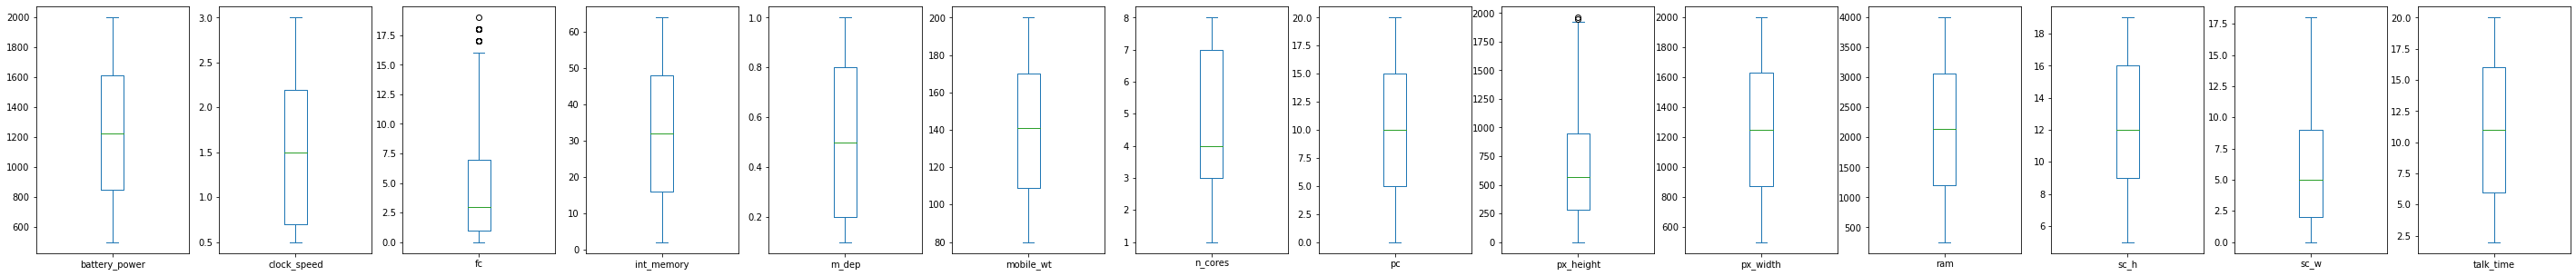

In [9]:
# visualizing individual box plots
mobile_numdf.plot(kind='box', subplots=True, figsize=(50, 5))
plt.show()

In [10]:
# detecting numerical features with outliers
def outlier_detect(col):
    q1, q3 = col.quantile([.25, .75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    l_count = len([i for i in col if i < lower])
    u_count = len([i for i in col if i > upper])
    out_tot = l_count + u_count # number of outliers
    return (q1, q3, iqr, lower, upper, out_tot)

outlier_df = pd.DataFrame(index=['Q1', 'Q3', 'IQR', 'Lower', 'Upper', 'Outliers'])
for feat in mobile_numdf.columns:
    outlier_df[feat] = mobile_numdf[feat].agg(outlier_detect)
outlier_df

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
Q1,851.75,0.70,1.0,16.0,0.2,109.0,3.0,5.0,282.75,874.750,1207.5,9.0,2.0,6.0
Q3,1615.25,2.20,7.0,48.0,0.8,170.0,7.0,15.0,947.25,1633.000,3064.5,16.0,9.0,16.0
IQR,763.50,1.50,6.0,32.0,0.6,61.0,4.0,10.0,664.50,758.250,1857.0,7.0,7.0,10.0
Lower,-293.50,-1.55,-8.0,-32.0,-0.7,17.5,-3.0,-10.0,-714.00,-262.625,-1578.0,-1.5,-8.5,-9.0
Upper,2760.50,4.45,16.0,96.0,1.7,261.5,13.0,30.0,1944.00,2770.375,5850.0,26.5,19.5,31.0
Outliers,0.00,0.00,18.0,0.0,0.0,0.0,0.0,0.0,2.00,0.000,0.0,0.0,0.0,0.0


In [11]:
# clamping numerical features with outliers
cl_df = mobile_numdf.copy()

for feature in cl_df.columns:
    q1, q3 = cl_df[feature].quantile([.25, .75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    cl_df[feature] = cl_df[feature].clip(lower, upper)

cl_df = pd.concat([cl_df, mobiledf[cat_features]], axis = 1)
cl_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,842,2.2,1,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,0,0,0,1
1,1021,0.5,0,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,1,1,1,0
2,563,0.5,2,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,1,1,1,0
3,615,2.5,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1,0,0
4,1821,1.2,13,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,0,1,1,1,0


## Q3. Normalize the data using range normalization (10 pts)
In this part, you are expected to use the clamped dataset in the previous question (`cl_df`). Withut using sklearn's range normalization procedure (i.e., `MinMaxScaler`), initialize a scaler and normalize your features to [0,1] range. Do not include the target feature in your range normalization operation.

In [12]:
# instead of cl use your clamped data frame
cl = cl_df.copy() # don't write this
normalize = lambda col: (col - col.min()) / (col.max() - col.min())
for attribute in cl.columns:
    cl[attribute] = cl[attribute].agg(normalize)
cl.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,0.227789,0.68,0.0625,0.080645,0.555556,0.900000,0.142857,0.10,0.010288,0.170895,0.612774,0.285714,0.388889,0.944444,0.0,0.0,0.0,0.0,0.0,1.0
1,0.347361,0.00,0.0000,0.822581,0.666667,0.466667,0.285714,0.30,0.465535,0.993324,0.634687,0.857143,0.166667,0.277778,1.0,1.0,1.0,1.0,1.0,0.0
2,0.041416,0.00,0.1250,0.629032,0.888889,0.541667,0.571429,0.30,0.649691,0.811749,0.627205,0.428571,0.111111,0.388889,1.0,1.0,1.0,1.0,1.0,0.0
3,0.076152,0.80,0.0000,0.129032,0.777778,0.425000,0.714286,0.45,0.625514,0.858478,0.671566,0.785714,0.444444,0.500000,1.0,0.0,0.0,1.0,0.0,0.0
4,0.881764,0.28,0.8125,0.677419,0.555556,0.508333,0.142857,0.70,0.621399,0.475300,0.308658,0.214286,0.111111,0.722222,1.0,0.0,1.0,1.0,1.0,0.0


In [13]:
minmax_norm = lambda col: (col - col.min()) / (col.max() - col.min())
cl_df = cl_df.apply(minmax_norm)
cl_df = pd.concat([cl_df, mobiledf[target]], axis = 1)
cl_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,...,sc_h,sc_w,talk_time,blue,dual_sim,four_g,three_g,touch_screen,wifi,price_range
0,0.227789,0.68,0.0625,0.080645,0.555556,0.900000,0.142857,0.10,0.010288,0.170895,...,0.285714,0.388889,0.944444,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.347361,0.00,0.0000,0.822581,0.666667,0.466667,0.285714,0.30,0.465535,0.993324,...,0.857143,0.166667,0.277778,1.0,1.0,1.0,1.0,1.0,0.0,2
2,0.041416,0.00,0.1250,0.629032,0.888889,0.541667,0.571429,0.30,0.649691,0.811749,...,0.428571,0.111111,0.388889,1.0,1.0,1.0,1.0,1.0,0.0,2
3,0.076152,0.80,0.0000,0.129032,0.777778,0.425000,0.714286,0.45,0.625514,0.858478,...,0.785714,0.444444,0.500000,1.0,0.0,0.0,1.0,0.0,0.0,2
4,0.881764,0.28,0.8125,0.677419,0.555556,0.508333,0.142857,0.70,0.621399,0.475300,...,0.214286,0.111111,0.722222,1.0,0.0,1.0,1.0,1.0,0.0,1


## Q4. Create a Nearest Neighbor classifier for classification (10 pts)
Using sklearn's k-nearest neighbors classifier (`KNeighborsClassifier`), initialize a similarity-based classification model. Set the number of nearest neighbors (`n_neighbors`) parameter to 1. Then, train and test the error rate of your classifier. Use 67% of the data for training and the rest (33%) for testing. Set the random state to the last two digits of your Panther ID (if it has leading 0s, remove them). You are expected to use the clamped and normalized data frame that you generated in Q2.

Print your accuracy score on testing dataset (Note: You can use `accuracy_score` from `sklearn.metrics`).

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [15]:
X = cl_df.drop(columns='price_range')
y = cl_df['price_range']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.67, random_state=11)

In [16]:
neighclf = KNeighborsClassifier(n_neighbors=1)
neighclf = neighclf.fit(Xtrain, ytrain)
ypred = neighclf.predict(Xtest)

In [17]:
acc = accuracy_score(ytest, ypred)
err = 1 - acc
print(f'KNN Classifier accuracy rate = {acc*100:.2f} % \nand error rate = {err*100:.2f} %')

KNN Classifier accuracy rate = 37.27 % 
and error rate = 62.73 %
